In [ ]:
import numpy as np
import cv2
import os

os.mkdir('train_label_images')

dir_path = 'train_labels'
image_dir_path = 'train_label_images'
for file in os.listdir(dir_path):
  filename = os.path.splitext(file)[0]
  img_array = np.load(os.path.join(dir_path, file))
  cv2.imwrite(os.path.join(image_dir_path, filename + '.JPG'), img_array)


In [1]:
import tensorflow as tf
import os
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np
import time
import glob 
import random

In [2]:
import pandas as pd

ids = pd.read_csv('train and test ids.csv')
path = 'Images'
img_list_X_train = []
img_list_X_test = []
for i in ids['train_ids']:
    img_list_X_train.append(os.path.join(path,'crop_row_' + str(i).zfill(3) + '.jpg'))
for i in ids['test_ids']:
    if not np.isnan(i):
        img_list_X_test.append(os.path.join(path,'crop_row_' + str(int(i)).zfill(3) + '.jpg'))

In [3]:
img_width = 320
img_height = 240
img_channels = 3
number_of_init_filters = 16

In [4]:
X_train = np.zeros((len(img_list_X_train), img_height, img_width, img_channels), dtype=np.uint8)
for i, img_path in enumerate(img_list_X_train):
    # read image
    img_train = imread(img_path)
    img_train = resize(img_train, (img_height, img_width, img_channels), mode='constant', preserve_range='True')
    X_train[i] = img_train

In [5]:
train_output_path1 = 'train_label_images'
img_list_y_train = []
for i in ids['train_ids']:
      img_list_y_train.append(os.path.join(train_output_path1,'crop_row_' + str(i).zfill(3) + '.JPG'))
y_train = np.zeros((len(img_list_y_train), img_height, img_width, 1), dtype=np.int32)
for i, img_path in enumerate(img_list_y_train):
    # read image
    img_train = imread(img_path)
    img_train = resize(img_train, (img_height, img_width, 1), mode='constant', preserve_range='True')
    y_train[i] = img_train

In [6]:
X_test = np.zeros((len(img_list_X_test), img_height, img_width, img_channels), dtype=np.uint8)
for i, img_path in enumerate(img_list_X_test):
    # read image
    img_test = imread(img_path)
    img_test = resize(img_test, (img_height, img_width, img_channels), mode='constant', preserve_range='True')
    X_test[i] = img_test

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset


/Users/balarusum/opt/anaconda3/envs/tensor-env/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/balarusum/opt/anaconda3/envs/tensor-env/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <F0D48035-EF9E-3141-9F63-566920E60D7C> /Users/balarusum/opt/anaconda3/envs/tensor-env/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <572F00C8-615A-31F8-BC32-777C2024F746> /Users/balarusum/opt/anaconda3/envs/tensor-env/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate

def linknet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    
    # Decoder
    up5 = Concatenate()([UpSampling2D((2, 2))(conv4), conv3])
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)
    
    up6 = Concatenate()([UpSampling2D((2, 2))(conv5), conv2])
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)
    
    up7 = Concatenate()([UpSampling2D((2, 2))(conv6), conv1])
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)
    
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv7)
    
    model = Model(inputs, outputs)
    return model

# Define the input shape and number of classes
input_shape = (img_height, img_width, img_channels)
num_classes = 2

# Create an instance of the LinkNet model
model = linknet(input_shape, num_classes)

# Compile the model with an appropriate optimizer and loss function
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


In [9]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
results = model.fit(X_train, y_train, validation_split=0.1, batch_size=4, epochs=20, callbacks=[early_stop])

model.save('model.h5')


Epoch 1/20


2023-05-07 12:23:55.279898: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


48/48 [==============================] - 456s 9s/step - loss: 3.1534 - sparse_categorical_accuracy: 0.7846 - val_loss: 0.4232 - val_sparse_categorical_accuracy: 0.8365
Epoch 2/20
48/48 [==============================] - 443s 9s/step - loss: 0.4187 - sparse_categorical_accuracy: 0.8350 - val_loss: 0.4118 - val_sparse_categorical_accuracy: 0.8345
Epoch 3/20
48/48 [==============================] - 498s 10s/step - loss: 0.4019 - sparse_categorical_accuracy: 0.8341 - val_loss: 0.3834 - val_sparse_categorical_accuracy: 0.8358
Epoch 4/20
48/48 [==============================] - 454s 9s/step - loss: 0.4114 - sparse_categorical_accuracy: 0.8348 - val_loss: 0.4074 - val_sparse_categorical_accuracy: 0.8366
Epoch 5/20
48/48 [==============================] - 461s 10s/step - loss: 0.3723 - sparse_categorical_accuracy: 0.8347 - val_loss: 0.4307 - val_sparse_categorical_accuracy: 0.8366
Epoch 6/20
48/48 [==============================] - 456s 10s/step - loss: 0.4001 - sparse_categorical_accuracy: 0.

In [10]:
# Convert the predictions to a numpy array and transpose the dimensions
predictions = model.predict(X_test)
predictions = predictions.transpose(0, 3, 1, 2)

# Threshold the probability map to obtain a binary mask
binary_mask = torch.where(torch.from_numpy(predictions[:, 1]) > 0.5, torch.tensor(1), torch.tensor(0))

# Convert the binary mask to a grayscale image
grayscale_image = (binary_mask * 255).numpy().astype('int32')


3/3 [==============================] - 34s 9s/step


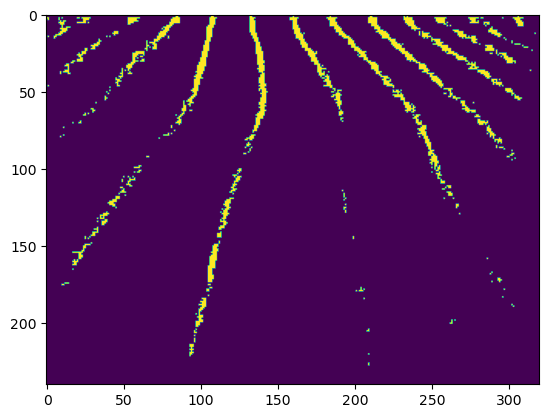

In [21]:
plt.imshow(grayscale_image[3])

In [17]:
rles = []

for i in range(grayscale_image.shape[0]):
    id = img_list_X_test[i][16:19]
    rle = encode_mask_to_rle(grayscale_image[i])
    rles.append(rle)
    
df = pd.DataFrame({'ids': [img_list_X_test[i][16:19]  for i in range(grayscale_image.shape[0])], 'labels': rles})

In [18]:
df.to_csv('Balaswamy_Rusum_2.csv', index=False)

In [ ]:
plt.imshow(resize(grayscale_image[3], (240,240,1)))

In [16]:
def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask 
    255 - mask 
    0 - background
    Returns encoded run length 
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)


def decode_rle_to_mask(rle, height = 240, width = 320):
    '''
    rle : run-length as string formated (start value, count)
    height : height of the mask 
    width : width of the mask
    returns binary mask
    '''
    rle = np.array(rle.split(' ')).reshape(-1, 2)
    mask = np.zeros((height*width))
    color = 255
    for i in rle:
        mask[int(i[0]):int(i[0])+int(i[1])] = color

    return mask.reshape(height, width)